In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from typing import Callable, Tuple

# Optimization with SciPy

## What is optimization?

- Problem
- Constraints
- Objective function
- Gradient
- Problem type
- Dimensionality

## Have we done optimization already?

1. Classic example: Least-squares linear regression

## Example problem

What is the maximal rectangle area's length/height that can fit within a parabola?  Let a = -1, b = 7, c = 4 for the parabola.

Variable names for the rectangle: l for length, h for height, origin_x, origin_y for the bottom-left origin of the rectangle.

In [14]:
def f_parabola(x: np.ndarray, a: float, b: float, c: float) -> np.ndarray:
    return a * np.square(x) + b * x + c

def quadratic_roots(a: float, b: float, c: float) -> Tuple[float, float]:
    root0 = (-b + np.sqrt(b ** 2 - 4 * a * c)) / (2 * a)
    root1 = (-b - np.sqrt(b ** 2 - 4 * a * c)) / (2 * a)
    return root0, root1

def rect_area(x: np.ndarray, a: float, b: float, c: float) -> np.ndarray:
    height = f_parabola(x, a, b, c)
    root0, root1 = quadratic_roots(a, b, c)
    length = (root1 - root0) + 2 * root0 - 2 * x # root1 - 2 * x + 2 * root0
    return length * height

In [15]:
parab_xmin, parab_xmax = quadratic_roots(-1, 7, 4)
print(parab_xmin, parab_xmax)
print((parab_xmax - parab_xmin) / 2 + parab_xmin)
print(rect_area(3.5, -1, 7, 4))

-0.5311288741492746 7.531128874149275
3.5
-8.630844204925712


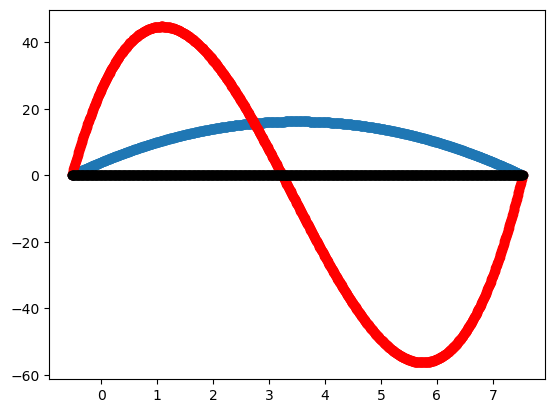

In [10]:
parab_x = np.linspace(start=parab_xmin, stop=parab_xmax, num=1000)
parab_y = f_parabola(parab_x, -1, 7, 4)
the_rectarea = rect_area(parab_x, -1, 7, 4)

plt.scatter(parab_x, parab_y)
plt.scatter(parab_x, the_rectarea, c="red")
plt.scatter(parab_x, np.zeros_like(parab_x), c="black")

## Fitting a rectangular prism under a paraboloid

This one is a little bit trickier.  We have to make a formulation that allows for origin_x and origin_y, where the height is the value of the paraboloid.